In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import os
import csv
from PIL import Image
import numpy as np

# Define the path to the dataset folder
dataset_path = 'C:/Users/path/to/img/data/FNNPK'

# Output CSV file
output_csv = 'C:/Users/file location/where/you/want to save/rgb intensity/image_rgb_intensity1.csv'

# Initialize a list to store image data
image_data = []

# Loop through the folders
for folder in ["FN", "-N", "-P", "-K"]:
    folder_path = os.path.join(dataset_path, folder)
    
    # Loop through each image in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Full path to the image
            image_path = os.path.join(folder_path, filename)
            
            # Open the image
            img = Image.open(image_path).convert("RGB")
            
            # Convert the image to a NumPy array
            img_array = np.array(img)
            
            # Calculate average RGB intensity
            avg_r = round(np.mean(img_array[:, :, 0]), 2)  # Red channel
            avg_g = round(np.mean(img_array[:, :, 1]), 2)  # Green channel
            avg_b = round(np.mean(img_array[:, :, 2]), 2)  # Blue channel
            
            # Store the data (filename, folder, avg_r, avg_g, avg_b)
            image_data.append([filename, avg_r, avg_g, avg_b])

# Write the results to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Filename", "Avg_R", "Avg_G", "Avg_B"])
    # Write data rows
    writer.writerows(image_data)

print(f"RGB intensity data saved to {output_csv}")


# Path setup and data loading
base_path = 'C:/Users/FNNPK'
rgb_data = pd.read_csv('C:/Users/image_rgb_intensity.csv')

def load_and_preprocess_data():
    images = []
    filenames = []
    labels = []
    
    print("Starting image loading process...")
    
    # Load images from all subfolders
    for folder in ['FN', '-N', '-P', '-K']:
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist")
            continue
            
        print(f"Processing folder: {folder}")
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, filename)
                try:
                    # Load with OpenCV
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224, 224))
                        img_array = img.astype(np.float32) / 255.0
                        
                        if img_array.shape == (224, 224, 3):
                            images.append(img_array)
                            filenames.append(filename)
                            labels.append(folder)  # Store folder name as label
                            
                            if len(images) % 50 == 0:
                                print(f"Processed {len(images)} images...")
                        else:
                            print(f"Skipping {filename}: Incorrect shape {img_array.shape}")
                    else:
                        print(f"Failed to load {filename}")
                except Exception as e:
                    print(f"Error loading {filename}: {str(e)}")
    
    if not images:
        raise ValueError("No images were successfully loaded! Check your image paths and file formats.")
    
    print(f"\nSuccessfully loaded {len(images)} images")
    
    # Convert to numpy array
    X = np.array(images)
    
    # Get corresponding RGB values
    y_data = rgb_data[rgb_data['Filename'].isin(filenames)]
    if len(y_data) != len(images):
        print(f"Warning: Mismatch between loaded images ({len(images)}) and RGB data ({len(y_data)})")
    
    # Prepare RGB values    
    y_rgb = y_data[['Avg_R', 'Avg_G', 'Avg_B']].values / 255.0
    
    # Prepare nutrition labels
    le = LabelEncoder()
    y_nutrition = le.fit_transform(labels)
    y_nutrition = tf.keras.utils.to_categorical(y_nutrition)
    
    return X, y_rgb, y_nutrition, filenames, le.classes_

def create_multitask_model():
    # Input layer
    inputs = layers.Input(shape=(224, 224, 3))
    
    # Shared CNN backbone
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten shared features
    shared_features = layers.Flatten()(x)
    
    # RGB intensity branch
    rgb_dense = layers.Dense(128, activation='relu')(shared_features)
    rgb_dropout = layers.Dropout(0.5)(rgb_dense)
    rgb_output = layers.Dense(3, activation='sigmoid', name='rgb_output')(rgb_dropout)
    
    # Nutrition deficiency branch
    nutrition_dense = layers.Dense(128, activation='relu')(shared_features)
    nutrition_dropout = layers.Dropout(0.3)(nutrition_dense)
    nutrition_output = layers.Dense(4, activation='softmax', name='nutrition_output')(nutrition_dropout)
    
    # Create model with multiple outputs
    model = Model(inputs=inputs, outputs=[rgb_output, nutrition_output])
    
    return model

def train_multitask_model_dynamic():
    # Load and preprocess data
    X, y_rgb, y_nutrition, filenames, classes = load_and_preprocess_data()
    
    # Split data
    X_train, X_test, y_rgb_train, y_rgb_test, y_nutrition_train, y_nutrition_test = train_test_split(
        X, y_rgb, y_nutrition, test_size=0.2, random_state=42
    )
    
    # Create model
    model = create_multitask_model()
    
    # Dynamic weight callback
    class DynamicWeightCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch < 15:  # Skip first two epochs
                return
                
            # Get current losses
            rgb_loss = logs.get('rgb_output_loss', 0)
            nutrition_loss = logs.get('nutrition_output_loss', 0)
            
            # Update weights based on relative task difficulty
            total_loss = rgb_loss + nutrition_loss
            if total_loss > 0:
                # Task with higher loss gets lower weight
                rgb_weight = nutrition_loss / total_loss
                nutrition_weight = rgb_loss / total_loss
                
                # Update model weights
                self.model.loss_weights = {
                    'rgb_output': rgb_weight,
                    'nutrition_output': nutrition_weight
                }
                
                # Print new weights every 5 epochs
                if (epoch + 1) % 5 == 0:
                    print(f"\nEpoch {epoch + 1} weights:")
                    print(f"RGB weight: {rgb_weight:.3f}")
                    print(f"Nutrition weight: {nutrition_weight:.3f}")
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss={
            'rgb_output': 'mse',
            'nutrition_output': 'categorical_crossentropy'
        },
        metrics={
            'rgb_output': 'mae',
            'nutrition_output': 'accuracy'
        },
        loss_weights={
            'rgb_output': 1.0,
            'nutrition_output': 1.0
        }
    )
    
    # Train model
    history = model.fit(
        X_train,
        {
            'rgb_output': y_rgb_train,
            'nutrition_output': y_nutrition_train
        },
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[
            DynamicWeightCallback(),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                start_from_epoch=15
            )
        ]
    )
    
    # Evaluate model
    evaluation = model.evaluate(
        X_test,
        {
            'rgb_output': y_rgb_test,
            'nutrition_output': y_nutrition_test
        }
    )
    print("\nTest Results:")
    for metric_name, value in zip(model.metrics_names, evaluation):
        print(f"{metric_name}: {value}")
    
    return model, history, classes


# Run the training
if __name__ == "__main__":
    try:
        model, history, classes = train_multitask_model_dynamic()
        
        # Save the model
        model.save('lettuce_multitask_model.h5')
        
        # Save the classes
        np.save('nutrition_classes.npy', classes)
        
    except Exception as e:
        print(f"Training failed: {str(e)}")

RGB intensity data saved to C:/Users/Mitesh/Desktop/jupyter project/image_rgb_intensity1.csv
Starting image loading process...
Processing folder: FN
Processing folder: -N
Processed 50 images...
Processing folder: -P
Processed 100 images...
Processing folder: -K
Processed 150 images...
Processed 200 images...

Successfully loaded 208 images
Epoch 1/50
5/5 [==============================] - 4s 500ms/step - loss: 1.4896 - rgb_output_loss: 0.0342 - nutrition_output_loss: 1.4554 - rgb_output_mae: 0.1470 - nutrition_output_accuracy: 0.2727 - val_loss: 1.3254 - val_rgb_output_loss: 0.0191 - val_nutrition_output_loss: 1.3063 - val_rgb_output_mae: 0.1066 - val_nutrition_output_accuracy: 0.3824
Epoch 2/50
5/5 [==============================] - 2s 421ms/step - loss: 1.3213 - rgb_output_loss: 0.0189 - nutrition_output_loss: 1.3024 - rgb_output_mae: 0.1106 - nutrition_output_accuracy: 0.2727 - val_loss: 1.2305 - val_rgb_output_loss: 0.0185 - val_nutrition_output_loss: 1.2120 - val_rgb_output_mae: 0

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import cv2

def plot_training_history(history):
    """
    Plot training history metrics including losses and accuracies
    """
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 6))
    
    # Plot RGB output loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['rgb_output_loss'], label='RGB Loss')
    plt.plot(history.history['val_rgb_output_loss'], label='Val RGB Loss')
    plt.title('RGB Output Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot RGB output MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['rgb_output_mae'], label='RGB MAE')
    plt.plot(history.history['val_rgb_output_mae'], label='Val RGB MAE')
    plt.title('RGB Output MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    # Plot nutrition classification loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['nutrition_output_loss'], label='Nutrition Loss')
    plt.plot(history.history['val_nutrition_output_loss'], label='Val Nutrition Loss')
    plt.title('Nutrition Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot nutrition classification accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history.history['nutrition_output_accuracy'], label='Nutrition Accuracy')
    plt.plot(history.history['val_nutrition_output_accuracy'], label='Val Nutrition Accuracy')
    plt.title('Nutrition Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
   # plt.close()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix for nutrition classification
    """
    # Compute confusion matrix
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    
    # Create heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Nutrition Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
   # plt.close()
    plt.show()


    

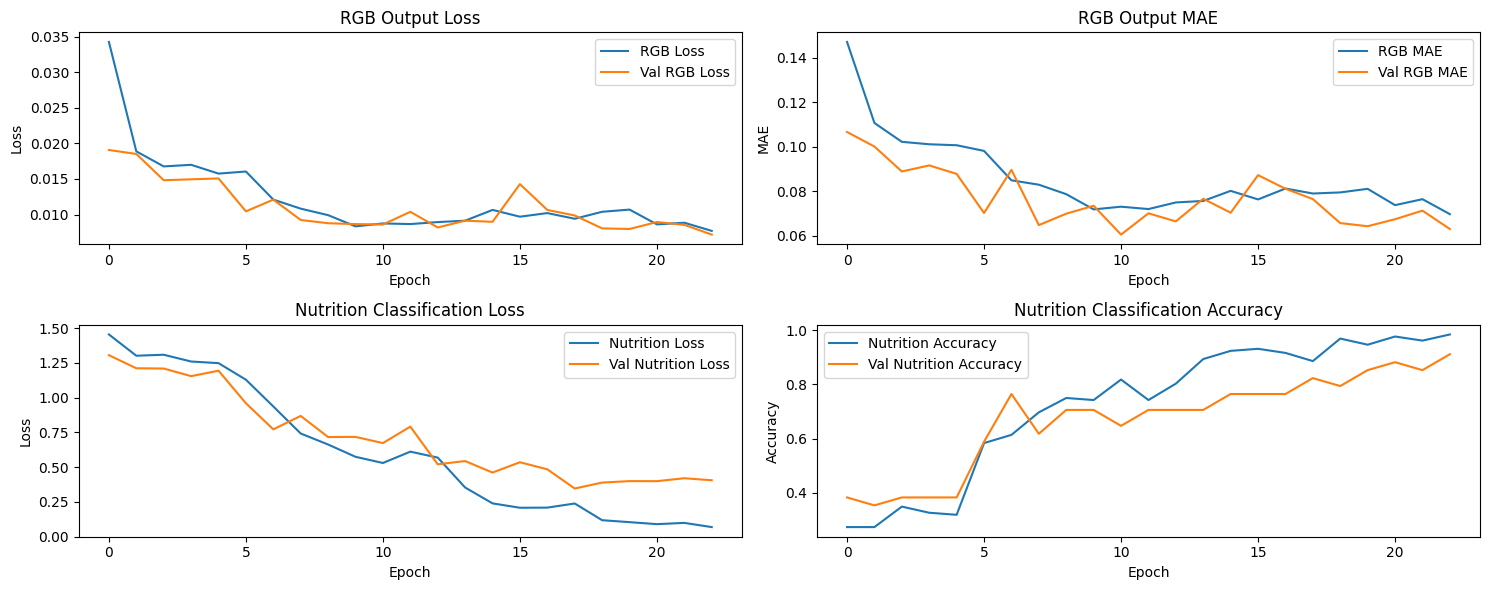

Starting image loading process...
Processing folder: FN
Processing folder: -N
Processed 50 images...
Processing folder: -P
Processed 100 images...
Processing folder: -K
Processed 150 images...
Processed 200 images...

Successfully loaded 208 images
7/7 [==============================] - 1s 94ms/step


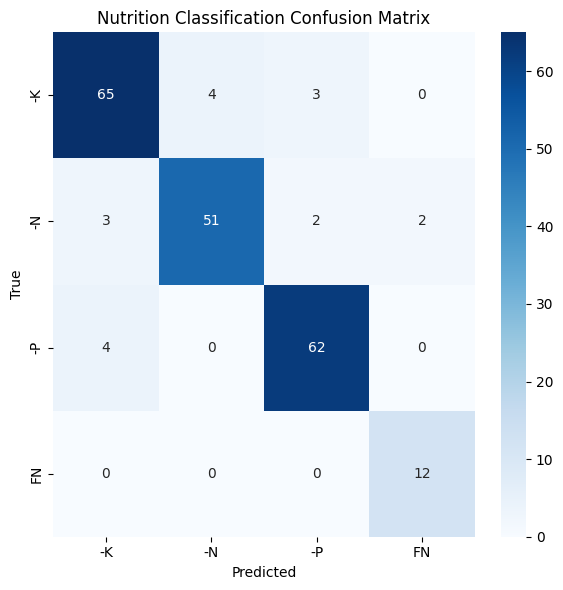

In [34]:
    plot_training_history(history)
    # Get predictions on test set
    X_test, y_rgb_test, y_nutrition_test, _, _ = load_and_preprocess_data()
    y_rgb_pred, y_nutrition_pred = model.predict(X_test)
    plot_confusion_matrix(y_nutrition_test, y_nutrition_pred, classes)